In [1]:
import numpy as np
import pandas as pd

from polyphys.probe.prober import fsd, stamps_report
from polyphys.manage.organizer import sort_filenames
from polyphys.visualize.plotter import ATTRIBUTE_LABELS as AL
from polyphys.visualize.plotter import SIZE_MEASURES_LABELS as SML
from polyphys.visualize.plotter import DUTCH_FEILD_COLORS as DF_colors
from polyphys.manage.parser import HnsCyl, HnsCub, SumRuleCyl
from polyphys.visualize.plotter import PROJECT_DETAILS as PD
from polyphys.visualize.plotter import TITLE_STYLES as TS

from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt


/Users/amirhsi/miniconda3/envs/polylab/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
project_name = 'SumRUleCyl'
spaces_dbs = glob(f"../../Datasets/{project_name}-runtimes/*.csv")
runtimes = []
for space_db in spaces_dbs:
    space_df = pd.read_csv(space_db)
    runtimes.append(space_df)

runtimes = pd.concat(runtimes)

In [28]:
# Step 1: Extract base ens# for grouping
runtimes['base_folder'] = runtimes['folder'].str.extract(r'(.*ens\d+)(?:_res|_incomplete)?$')
# Step 2: Group by the new base_folder column and aggregate
def aggregate_rows(group):
    if len(group) > 1:
        return pd.Series({
            'total_runtime_sec': group['total_runtime_sec'].sum(),
            'n_cores': group.iloc[0]['n_cores'],
            'folder': group['base_folder'].iloc[0]  # Use the base folder name for the new row
        })
    else:
        return pd.Series({
            'total_runtime_sec': group['total_runtime_sec'].iloc[0],
            'n_cores': group['n_cores'].iloc[0],
            'folder': group['folder'].iloc[0]  # Keep the original folder name if no merging needed
        })

# Apply aggregation to each group
merged_df = runtimes.groupby('base_folder').apply(aggregate_rows).reset_index(drop=True)

In [41]:
merged_df['n_atoms'] = merged_df['folder'].apply(
    lambda x: SumRuleCyl(x,'whole', 'cylindrical', 'bug', 'linear', ispath=False).nmon +
    SumRuleCyl(x,'whole', 'cylindrical', 'bug', 'linear', ispath=False).ncrowd 
)
merged_df['ensemble_long'] = merged_df['folder'].apply(
    lambda x: SumRuleCyl(x,'whole', 'cylindrical', 'bug', 'linear', ispath=False).ensemble
) 
merged_df['total_runtime_hr'] = merged_df['total_runtime_sec'] / 3600
merged_avg = merged_df.groupby('ensemble_long').agg({'n_atoms': 'first', 'n_cores': 'first', 'total_runtime_hr': 'max'})

/Users/amirhsi/Library/CloudStorage/OneDrive-UniversityofWaterloo/PhD Research/Jupyter/PolyPhys/polyphys/manage/parser.py:682: UserWarning: It is assumed that 'nc' is the last attribute short-key in a lineage_name of types: 'ensemble', 'ensemble_long', 'whole', 'segment'.
  warnings.warn(convention_warning, UserWarning)


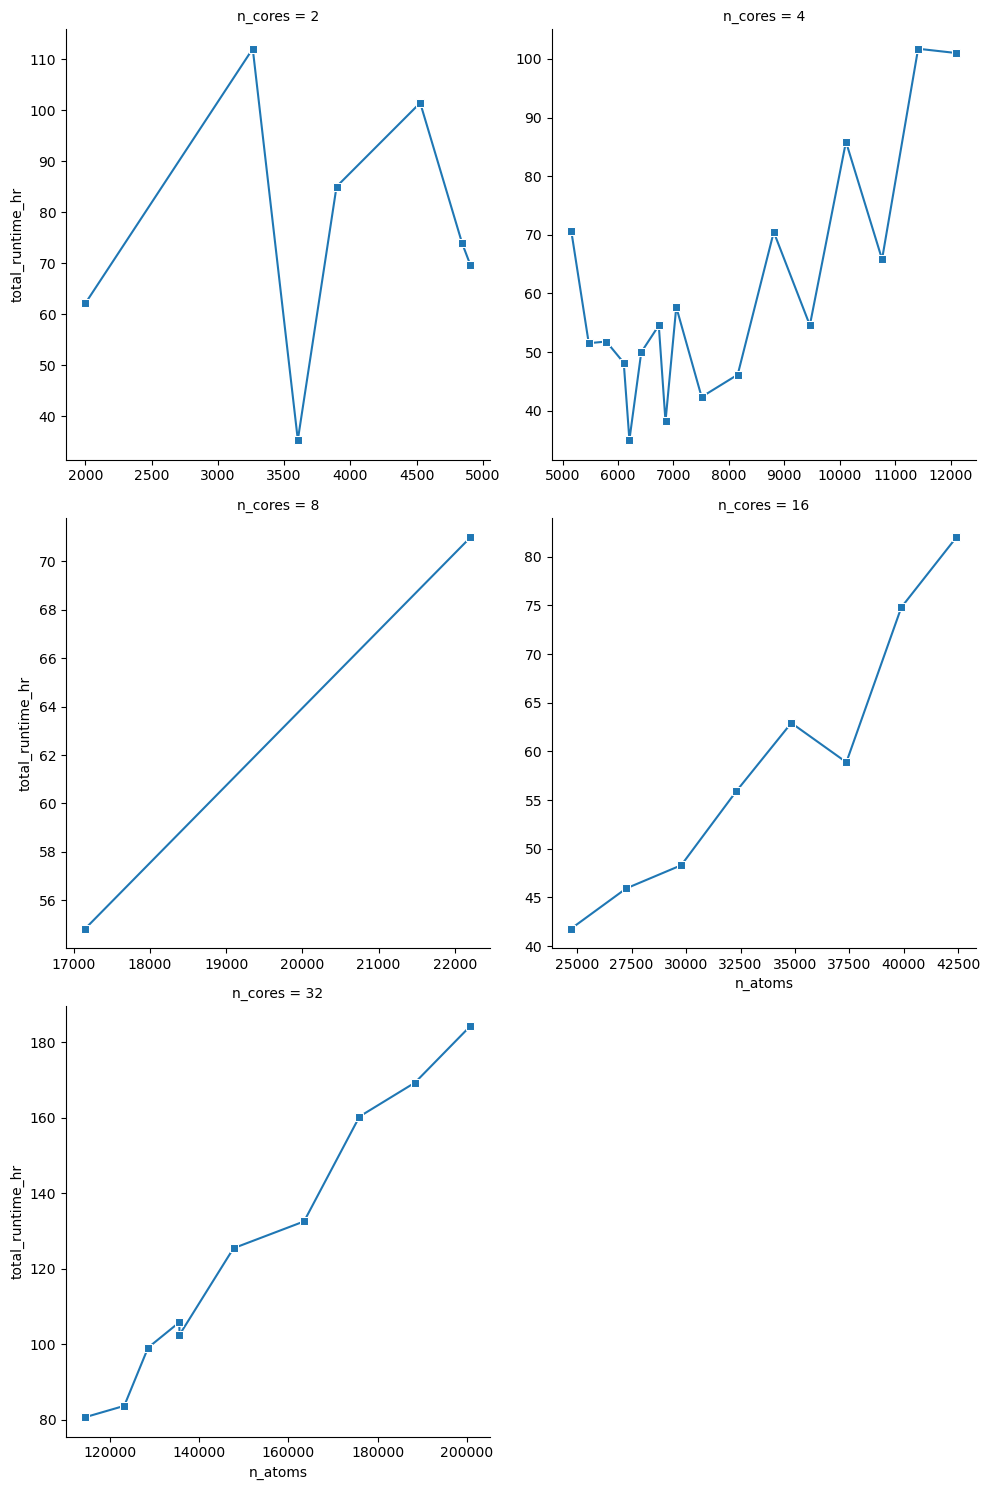

In [42]:
sns.relplot(
    data=merged_avg,
    x='n_atoms',
    y='total_runtime_hr',
    col='n_cores',
    col_wrap=2,
    kind='line',
    marker='s',
    facet_kws={'sharex':False, 'sharey': False}
)